<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/PSW_with_google_mobility_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will do the same propensisty weighted methods of causal inference we have done before with google mobility dataset, but with a slight twist. We will
1. Do causal inference with all 6 columns, even if some columns have a lot of nulls. (We are doing propensisty weighing and not propensisty matching so missing data shouldn't be that much of an issue.)
2. Use the glass delta to characterize the causal effect in terms standard deviations. (for example changing one variable by 3% when the base value is 20% is different from changing 3% when the base value is 1%.)

# 0. Go do data directory

In [1]:
cd drive/My\ Drive/covid/PSM/data

/content/drive/My Drive/covid/PSM/data


In [2]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
county_data_with_reduced_covariates_with_SIP.csv
final_data_google_and_safe_graph_up_to_6_1.csv
google_mobility.csv
social_dist_aggregated_on_county.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1. load R packages into Colab

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
# for box and whisker plot
%%R
install.packages('lattice')
library(lattice)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lattice_0.20-41.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 389631 bytes (380 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [6]:
# install package for gradient boosting machine to estimate propensity score
%%R
install.packages('twang')
library(twang)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/twang_1.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1256084 bytes (1.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [7]:
%%R
install.packages('survey')
library('survey')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survey_4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1558121 bytes (1.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

# 1. load/preprocess data

In [8]:
data = pd.read_csv('final_data_google_and_safe_graph_up_to_6_1.csv')

In [9]:
data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_parks_percent_change_6_1,avg_transit_stations_percent_change_6_1,avg_workplaces_percent_change_6_1,avg_residential_percent_change_6_1
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-34.000000,NaN,-22.481481,9.480000
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,23.500000,-6.361111,-19.777778,6.564815
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,NaN,NaN,-15.333333,NaN
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,NaN,NaN,-18.175926,NaN
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,NaN,NaN,-21.111111,8.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-11.537037,7.305882,NaN,13.888889,-20.231481,7.120000
2824,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,56039.0,-39.369048,-17.661017,-24.018868,-38.691358,-37.574074,NaN
2825,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,-1.125000,14.352941,NaN,12.537037,-16.435185,NaN
2826,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-2.767442,-12.000000,NaN,NaN,-20.960526,NaN


In [10]:
data.isnull().sum()

state                                              0
state_code                                         0
State Name                                         0
cnamelong                                          0
county_code                                        0
diff_in_perc_at_home                               0
SIP?                                               0
Median Household Income                            0
% Rural                                            0
Population_y                                       0
political_diff                                     0
% less than 18 years of age                        0
% 65 and over                                      0
% Asian                                            0
% Black                                            0
% Hispanic                                         0
% Non-Hispanic White                               0
census_fips_code                                   0
avg_retail_and_recreation_percent_change_6_1  

because some of the R functions expect non-null data, I can't keep null data when in my dataframe, but obviously for each column there are a unique set of dataset that doesn't contain null data in that column. For example, to analyze `avg_retail_and_recreation_percent_change_6_1` we only need to drop `249` data points, for `avg_parks_percent_change_6_1` we only need to drop `1819` data points, and so on.

I will just create 6 datasets, each one corresponding to having all non-null data for that column, and analyze those dataset separately. There might be better ways to do it in R land but I am not so familiar with R functions, so this is what I am going to do now.

In [11]:
data_retail = data.dropna(subset = ['avg_retail_and_recreation_percent_change_6_1'])
data_grocery = data.dropna(subset = ['avg_grocery_and_pharmacy_percent_change_6_1'])
data_parks = data.dropna(subset = ['avg_parks_percent_change_6_1'])
data_transit = data.dropna(subset = ['avg_transit_stations_percent_change_6_1'])
data_workplaces = data.dropna(subset = ['avg_workplaces_percent_change_6_1'])
data_residential = data.dropna(subset = ['avg_residential_percent_change_6_1'])

First need to write a function in R that encapsulates our analysis with causal inference, given a specific dataset, then we can do analysis on our 6 specific datasets by calling this function 6 times.

In [12]:
%%R
causal_analysis_on_dataset <- function(dataframe, variable) {
    logitModel <- glm(SIP.~Median.Household.Income + X..Rural +
                  political_diff+
                  X..Asian + X..Black + 
                  X..Non.Hispanic.White +
                  X..Hispanic + Population_y, data = dataframe, family = "binomial")

    # put the propensity score predicted by logistic regression
    # into a new column in the dataframe.
    dataframe$weights<-predict(logitModel, type="response")
    # convert 0, 1 to categories, as is required by the box whisker function
    dataframe$factor_SIP <- factor(dataframe$SIP.)
    box_whisker_plot = bwplot(weights~factor_SIP, data = dataframe, ylab = "propensity score", 
                              xlab = "Shelter in place?", main = 'propensity score box-whisker plot of counties with/without SIP',
                              auto.key = TRUE)
    print(box_whisker_plot)
    
    dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))
    print(with(dataframe, by(weight_ATE, SIP., summary)))
    # deal with extreme weights
    dataframe$weight_ATE_truncated <- with(dataframe, 
                                           ifelse(weight_ATE > quantile(weight_ATE, 0.99),
                                                  quantile(weight_ATE, 0.99),
                                                  weight_ATE))
    print(with(data = dataframe, by(weight_ATE_truncated, SIP., summary)))

    covariateNames <- c('Median.Household.Income', 'X..Rural', 'political_diff',
                        'X..Asian', 'X..Black', 'X..Non.Hispanic.White', 'X..Hispanic',
                        'Population_y')
    
    # sampw has to be set here or else will not get std.eff.sz which is what we want
    # since we don't have sampling weight, we set it to 1
    balanceTable <- bal.stat(dataframe, vars = covariateNames, treat.var = 'SIP.',
                             w.all = dataframe$weight_ATE_truncated, sampw = 1,
                             get.ks = F, estimand = 'ATE', multinom = F)
    balance_results <- balanceTable$results
    round(balance_results,3)

    surveyDesignCovid <- svydesign(ids=~0, weights = ~weight_ATE_truncated,
                                   data = dataframe)
    # to obtain standard errors for propensity weighted results,
    # we need to bootstrap.
    
    # we have variable = 'avg_retail_and_recreation_percent_change_6_1',
    # but we need to make a formula of ~avg_retail_and_recreation_percent_change_6_1
    # to pass in the function below.
    formula_strings = c('~', variable)
    formula = as.formula(paste(formula_strings, collapse = ''))

    surveyDesignBoot <- as.svrepdesign(surveyDesignCovid, type=c('bootstrap'), replicates=1000)
    weightedMeans <- svyby(formula = formula, by = ~SIP., design = surveyDesignBoot,
                           FUN = svymean, covmat = TRUE)
    print(weightedMeans)
    ATE_covid <- svycontrast(weightedMeans, contrasts = c(-1,1))
    print('the effect size of having shelter in place on retail_and_recreation behavioral data')
    print(ATE_covid)
    
    # to calculate glass delta - to put effect size in standard deviations.
    weightedVars <- svyby(formula = formula, by=~SIP., design = surveyDesignBoot,
                          FUN=svyvar,covmat=TRUE)
    print('weighted Variance:')
    print(weightedVars)
    print('glass delta of effect is:')
    print(ATE_covid[[1]][[1]] / sqrt(weightedVars[[2]][[1]]))
}

# 2. causal analysis on variable `avg_retail_and_recreation_percent_change_6_1`

SIP.: 0
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.060    3.115    4.855   16.656    8.166 1307.543 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.045   1.106   1.165   1.179  25.361 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.060   3.115   4.855   6.215   8.166  15.017 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.045   1.106   1.159   1.179  15.017 
  SIP. avg_retail_and_recreation_percent_change_6_1        se
0    0                                    -12.37588 0.9455239
1    1                                    -14.05778 0.2865985
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -1.6819 0.9686
[1] "weighted Variance:"
  SIP.      V1        se
0    0 203.539 29.633303
1    1 148.454  6.989172
[1] "glass del

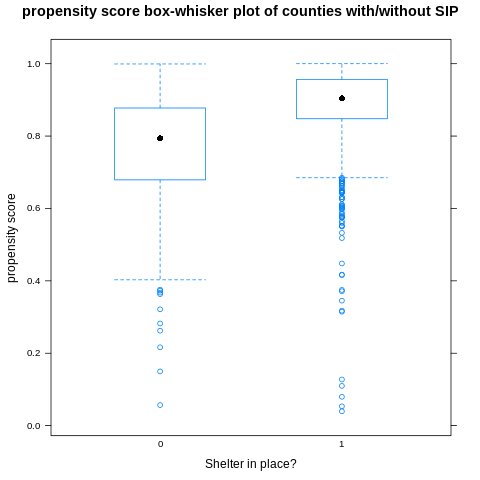

In [14]:
%%R -i data_retail
causal_analysis_on_dataset(data_retail, 'avg_retail_and_recreation_percent_change_6_1')

# 3. causal analysis on variable `avg_grocery_and_pharmacy_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.128   3.284   5.408  13.936   8.881 721.714 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.042   1.098   1.165   1.164  52.085 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.128   3.284   5.408   6.771   8.881  16.154 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.042   1.098   1.148   1.164  16.154 
  SIP. avg_grocery_and_pharmacy_percent_change_6_1        se
0    0                                   4.8509931 0.7079819
1    1                                   0.9000273 0.2540032
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast    SE
contrast   -3.951 0.748
[1] "weighted Variance:"
  SIP.        V1        se
0    0 121.29682 21.593209
1    1  79.22438  5.290276
[1] "glass delta of effec

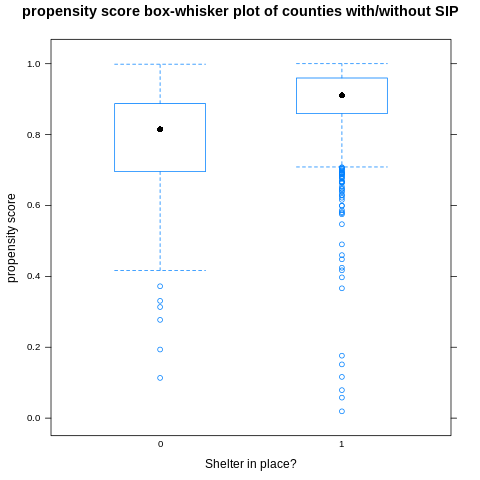

In [15]:
%%R -i data_grocery
causal_analysis_on_dataset(data_grocery, 'avg_grocery_and_pharmacy_percent_change_6_1')

# 4. causal analysis on variable `avg_parks_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.567   3.920   7.600  15.507  13.536 250.633 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.008   1.033   1.070   1.078   3.873 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.567   3.920   7.600   8.985  13.536  18.079 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.008   1.033   1.070   1.078   3.873 
  SIP. avg_parks_percent_change_6_1       se
0    0                    11.405346 6.752461
1    1                     4.336327 1.035452
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast   -7.069 6.8651
[1] "weighted Variance:"
  SIP.       V1        se
0    0 1798.784 290.08733
1    1 1013.801  57.10568
[1] "glass delta of effect is:"
[1] -0.1666747


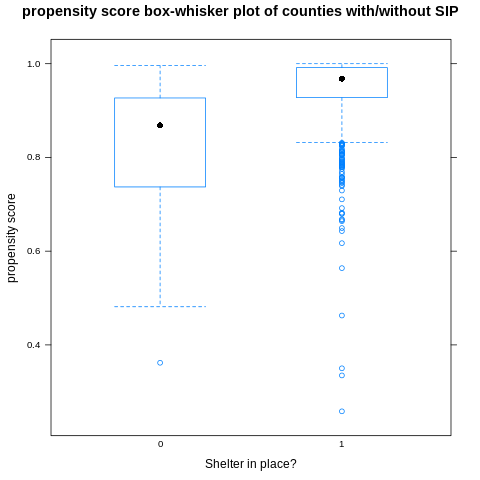

In [16]:
%%R -i data_parks
causal_analysis_on_dataset(data_parks, 'avg_parks_percent_change_6_1')

# 5. causal analysis on variable `avg_transit_stations_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.364   2.680   4.813  12.315   9.662 180.483 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.015   1.060   1.114   1.139   7.872 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.364   2.680   4.813   7.513   9.662  20.919 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.015   1.060   1.114   1.139   7.872 
  SIP. avg_transit_stations_percent_change_6_1        se
0    0                               -8.821655 1.4438655
1    1                              -17.308444 0.5401612
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -8.4868 1.5323
[1] "weighted Variance:"
  SIP.       V1       se
0    0 170.9460 28.95268
1    1 269.4515 12.14101
[1] "glass delta of effect is:"
[1] -0.64

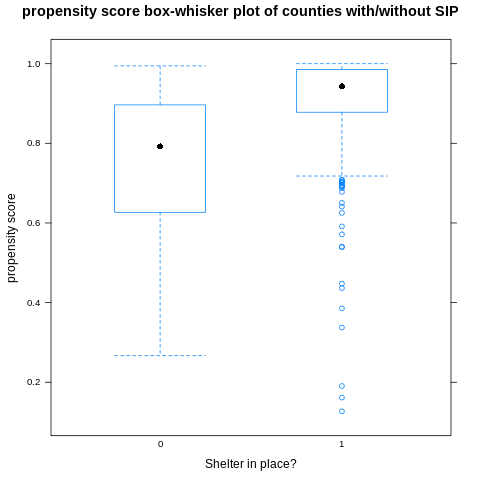

In [17]:
%%R -i data_transit
causal_analysis_on_dataset(data_transit, 'avg_transit_stations_percent_change_6_1')

# 6. causal analysis on variable `avg_workplaces_percent_change_6_1`

SIP.: 0
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.097    3.295    4.727   17.809    7.001 1777.097 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.053   1.137   1.174   1.211  24.445 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.097   3.295   4.727   5.815   7.001  15.366 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.053   1.137   1.170   1.211  15.366 
  SIP. avg_workplaces_percent_change_6_1        se
0    0                         -21.51483 0.4569665
1    1                         -23.77986 0.1466122
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast   -2.265 0.4805
[1] "weighted Variance:"
  SIP.       V1        se
0    0 47.27080 11.547258
1    1 41.68823  2.187482
[1] "glass delta of effect is:"
[1] -0.32944

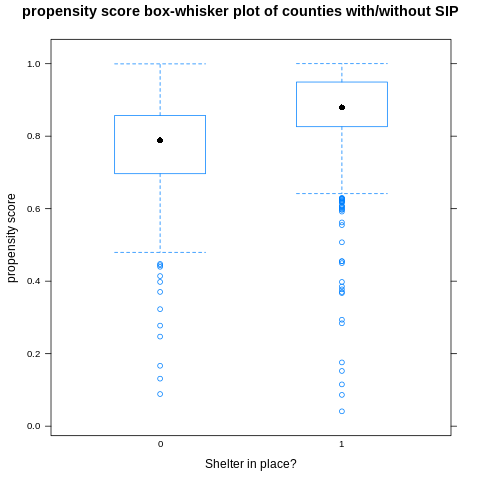

In [18]:
%%R -i data_workplaces
causal_analysis_on_dataset(data_workplaces, 'avg_workplaces_percent_change_6_1')

# 7. causal analysis on variable `avg_residential_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.348   3.262   6.334  14.082  12.358 209.930 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.017   1.049   1.098   1.104  13.769 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.348   3.262   6.334   8.872  12.358  22.402 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.017   1.049   1.098   1.104  13.769 
  SIP. avg_residential_percent_change_6_1        se
0    0                           6.678770 0.4693901
1    1                           8.345577 0.1169473
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast   1.6668 0.4916
[1] "weighted Variance:"
  SIP.       V1       se
0    0 15.20767 2.305391
1    1 18.25367 0.749873
[1] "glass delta of effect is:"
[1] 0.4274193


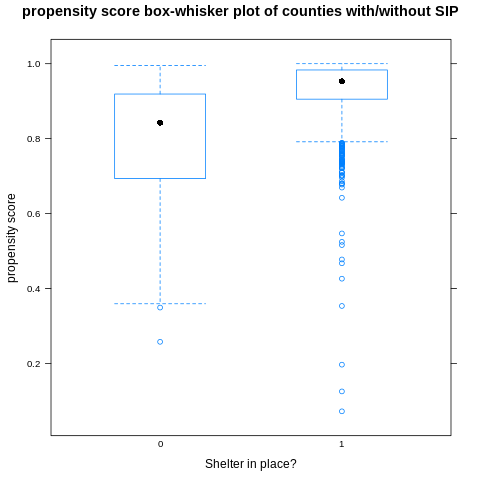

In [19]:
%%R -i data_residential
causal_analysis_on_dataset(data_residential, 'avg_residential_percent_change_6_1')

# Conclusion

As we can see, the glass delta is between about `0.1` and `0.6` in absolute value for our 6 behavioral response variables. the largest behavioral change is the transit, which SIP changes that by `0.6` standard deviation (variance is obtained by boostrapping over 1000 subsamples of our data). \\
the change on residential is about `0.4` standard deviation, which sort of matches our result before.